In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

In [2]:
def generate_data(func, n_samples=100, n_dim=2):
    # Generate data in the form of a 2D tensor for neural network input
    X = torch.linspace(0, 1, n_samples * n_dim).view(n_samples, n_dim)
    
    # Shuffle the input data
    shuffled_indices = torch.randperm(X.size(0))
    X_shuffled = X[shuffled_indices]
    
    # Apply the function to the shuffled X values
    y = func(X_shuffled)
    
    return X_shuffled, y

In [3]:
def f1(X):
    # Extract x1 and x2 from the columns of the 2D tensor X
    x1 = X[:, 0]  # First column
    x2 = X[:, 1]  # Second column
    
    return torch.cos(x1) + torch.sin(x2)

In [4]:
def indefinite_integral_f1(X):
    # Extract x1 and x2 from the columns of the 2D tensor X
    x1 = X[:, 0]  # First column
    x2 = X[:, 1]  # Second column

    return -x1 * torch.cos(x2) + x2 * torch.sin(x1)

In [5]:
def definite_integral_f1(A, B):

    return indefinite_integral_f1(B) - indefinite_integral_f1(A)

In [6]:
X, y = generate_data(f1, n_dim=2, n_samples=5)
integr = indefinite_integral_f1(X)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Neural network constructor for a multi-layer perceptron.
        @param input_size  Number of features in the input data
        @param hidden_size Number of neurons in the hidden layer
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size)  # input -> hidden
        self.sigmoid_activation = nn.Sigmoid()  # Activation function
        self.output_layer = nn.Linear(hidden_size, 1)  # hidden -> output
    
    def forward(self, x):
        """
        Forward pass through the network.
        @param x  Input data
        @returns   The network's output
        """
        x = self.input_hidden_layer(x)  # Pass through input-hidden layer
        x = self.sigmoid_activation(x)  # Apply activation function
        x = self.output_layer(x)  # Pass through output layer
        return x

In [8]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
    Train the model.
    @param model        The model to be trained
    @param criterion    Loss function
    @param optimizer    Optimization algorithm
    @param x_train      Training inputs
    @param y_train      True labels
    @param epochs       Number of training epochs
    """
    loss_history = []
    for epoch in range(epochs):
        predictions = model(x_train)  # Forward pass
        loss = criterion(predictions, y_train)  # Compute the loss

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}')
    
    return loss_history

In [9]:
def test_model(model, criterion, x_test, y_test):
    """
    Test the model.
    @param model        The trained model
    @param criterion    Loss function
    @param x_test       Test inputs
    @param y_test       True labels
    """
    with torch.no_grad():  # Disable gradient calculation for testing
        predictions = model(x_test)  # Forward pass
        loss = criterion(predictions, y_test)  # Compute the loss

    return loss.item()

In [31]:
def predict_with_model(model, x_test):

    with torch.no_grad():
        predictions = model(x_test)

    return predictions

In [10]:
input_size = 2  # Set the number of input dimensions
hidden_size = 20  # Set the number of neurons in the hidden layer
n_samples = 10000  # Number of samples for training
epochs = 1000  # Number of epochs
learning_rate = 0.001

In [11]:
X_train, y_train = generate_data(f1, n_samples=n_samples, n_dim=input_size)

In [12]:
model = MLP(input_size, hidden_size)

In [13]:
summary(model, input_size=(input_size,)) # подробное описание модели

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
           Sigmoid-2                   [-1, 20]               0
            Linear-3                    [-1, 1]              21
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, X_train, y_train, epochs)

/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.0249002147
Epoch [200/1000], Loss: 0.0171447881
Epoch [300/1000], Loss: 0.0167659018
Epoch [400/1000], Loss: 0.0163917672
Epoch [500/1000], Loss: 0.0160525609
Epoch [600/1000], Loss: 0.0157652367
Epoch [700/1000], Loss: 0.0155361267
Epoch [800/1000], Loss: 0.0153635684
Epoch [900/1000], Loss: 0.0152406525
Epoch [1000/1000], Loss: 0.0151578253


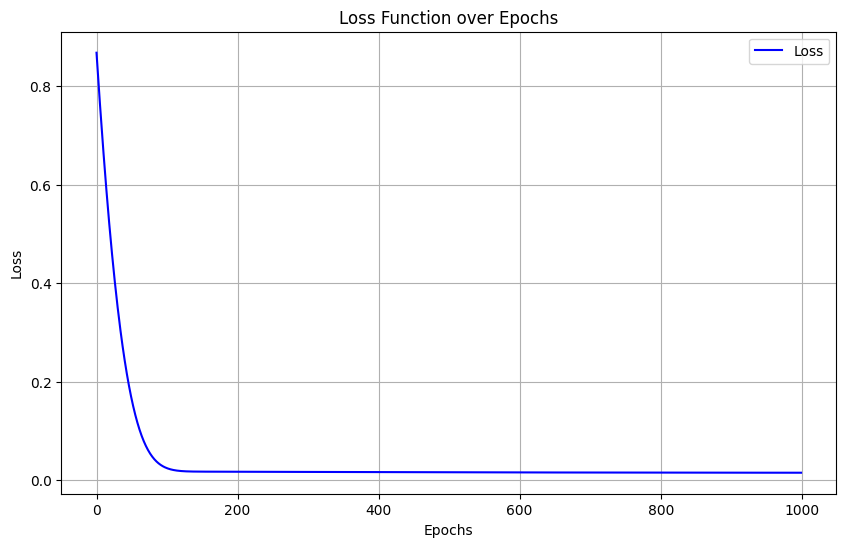

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy()
    # w1 = [w1[:, i] for i in range(w1.shape[1])]
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

In [17]:
b1, w1, b2, w2 = extract_model_params(model)
b1.shape, w1.shape, b2.shape, w2.shape

((20,), (20, 2), (1,), (20,))

In [25]:
b1, w1, b2, w2

(array([-0.6946223 , -0.04888429, -0.19624652, -0.58437485, -0.37704802,
         0.15595804,  0.1771961 , -0.16657959,  0.37996888, -0.16237897,
         0.08987103,  0.39621317,  0.3120149 ,  0.10495432, -0.02375384,
        -0.15677467, -0.26763734,  0.378303  ,  0.51248825, -0.49541795],
       dtype=float32),
 array([[-0.43147385,  0.562421  ],
        [ 0.18849896,  0.49672544],
        [-0.20231706,  0.00758159],
        [-0.18995114,  0.6743529 ],
        [ 0.5051995 , -0.6110522 ],
        [ 0.4443427 ,  0.6891412 ],
        [ 0.40806758,  0.46986973],
        [-0.42398956, -0.2337212 ],
        [ 0.50691915, -0.67621034],
        [-0.25660592,  0.38326892],
        [ 0.33967417, -0.54490316],
        [ 0.25651833, -0.4061526 ],
        [ 0.2179358 , -0.36111334],
        [ 0.3291684 , -0.23612154],
        [ 0.17006423, -0.7193213 ],
        [-0.54774433,  0.18612233],
        [ 0.4665954 ,  0.20643753],
        [ 0.09767294, -0.27842063],
        [-0.3076239 , -0.50198156],


In [26]:
def get_NN_integral(alpha1, alpha2, beta1, beta2, b1, w1, b2, w2):
    """
    Function that implements the new analytical integral based on the provided formulae.
    
    @param alpha1  Lower limit of integration for the first dimension
    @param alpha2  Lower limit of integration for the second dimension
    @param beta1   Upper limit of integration for the first dimension
    @param beta2   Upper limit of integration for the second dimension
    @param b1      Shifts between input and hidden layers
    @param w1      Weights between input and hidden layers
    @param b2      Shifts between hidden and output layers
    @param w2      Weights between hidden and output layers

    @returns       The analytical integral based on the neural network parameters.
    """
    
    def Phi_j(alpha1, alpha2, beta1, beta2, b1_j, w1_j):
        """
        Nested function implementing the difference of polylogarithms as defined in the new formula.
        
        @param alpha1  Lower limit of integration for the first dimension
        @param alpha2  Lower limit of integration for the second dimension
        @param beta1   Upper limit of integration for the first dimension
        @param beta2   Upper limit of integration for the second dimension
        @param b1_j    j-th shift between input and hidden layers
        @param w1_j    j-th weight between input and hidden layers
        @param w2_j    j-th weight between hidden and output layers
        
        @returns       Difference of polylogarithms as defined in the new formula.
        """
        w1_1j = w1_j[0]
        w1_2j = w1_j[1]
        print(w1_1j, w1_2j)
        term_alpha1_alpha1 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * alpha1))  # Li_2 term for alpha1, alpha1
        term_alpha1_beta2  = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * beta2))   # Li_2 term for alpha1, beta2
        term_beta1_alpha2  = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * alpha2))    # Li_2 term for beta1, alpha2
        term_beta1_beta2   = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * beta2))     # Li_2 term for beta1, beta2
        
        return term_alpha1_alpha1 - term_alpha1_beta2 - term_beta1_alpha2 - term_beta1_beta2

    integral_sum = 0  # Sum of integrals
    
    # Sum over all j
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha1, alpha2, beta1, beta2, b1_j, w1_j)  # Compute the difference of polylogarithms
        integral_sum += w2_j * ((beta1 - alpha1) * (beta2 - alpha2) + (phi_j / (w1_j[0] * w1_j[1])))  # Accumulate integral for sum
    
    # Final result based on the new formula
    return b2 * (beta1 - alpha1) * (beta2 - alpha2) + integral_sum  # Full formula result

In [27]:
intgr = get_NN_integral(0.0, 0.0, 0.5, 0.5, b1, w1, b2, w2)
intgr

-0.43147385 0.562421
0.18849896 0.49672544
-0.20231706 0.0075815935
-0.18995114 0.6743529
0.5051995 -0.6110522
0.4443427 0.6891412
0.40806758 0.46986973
-0.42398956 -0.2337212
0.50691915 -0.67621034
-0.25660592 0.38326892
0.33967417 -0.54490316
0.25651833 -0.4061526
0.2179358 -0.36111334
0.3291684 -0.23612154
0.17006423 -0.7193213
-0.54774433 0.18612233
0.4665954 0.20643753
0.09767294 -0.27842063
-0.3076239 -0.50198156
0.65097594 -0.58287257


array([mpf('136.16486829524922')], dtype=object)

In [34]:
x_test, y_test = generate_data(f1, 100, 2)

In [35]:
test_result = test_model(model, criterion, x_test, y_test)
test_result

/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.015412969514727592

In [36]:
predict_with_model(model, x_test)

tensor([[1.3003],
        [1.2975],
        [1.3152],
        [1.2901],
        [1.2983],
        [1.2879],
        [1.3052],
        [1.3140],
        [1.2853],
        [1.2963],
        [1.3018],
        [1.2951],
        [1.3117],
        [1.2914],
        [1.2862],
        [1.3173],
        [1.2799],
        [1.2918],
        [1.3111],
        [1.3026],
        [1.2884],
        [1.2987],
        [1.2922],
        [1.2959],
        [1.2849],
        [1.3029],
        [1.3149],
        [1.2934],
        [1.2930],
        [1.3087],
        [1.3094],
        [1.2999],
        [1.3121],
        [1.3176],
        [1.2971],
        [1.3167],
        [1.3007],
        [1.2905],
        [1.2892],
        [1.3077],
        [1.3143],
        [1.3084],
        [1.2909],
        [1.3114],
        [1.3134],
        [1.3137],
        [1.3164],
        [1.3097],
        [1.3080],
        [1.3170],
        [1.3014],
        [1.2955],
        [1.3124],
        [1.2939],
        [1.3022],
        [1